# COVİD-19 CAN KAYBI TAHMİNİ 

In [43]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv(r'corona.csv') 
df.head()

,DAY,TESTS,POSITIVE,DEAD_TODAY,POSITIVE_RATIO,DEAD_POSITIVE_RATIO,DEAD_TOMORROW
0,14.3.2020,500,6,0,0.012000,0.000000,0.0
1,15.3.2020,845,12,0,0.014201,0.000000,0.0
2,16.3.2020,1000,29,0,0.029000,0.000000,1.0
3,17.3.2020,2000,51,1,0.025500,0.019608,1.0
4,18.3.2020,2500,93,1,0.037200,0.010753,2.0


In [45]:
df= df[['DAY','DEAD_TODAY','DEAD_TOMORROW']].copy()
df.tail()

,DAY,DEAD_TODAY,DEAD_TOMORROW
288,27.12.2020,254,257.0
289,28.12.2020,257,253.0
290,29.12.2020,253,254.0
291,30.12.2020,254,239.0
292,31.12.2020,239,NaN


In [46]:
#Gün sayısı
len(df.index)


293

In [47]:
#Günlük vefat sayısı ortalaması
df["DEAD_TODAY"].mean()


71.27986348122867

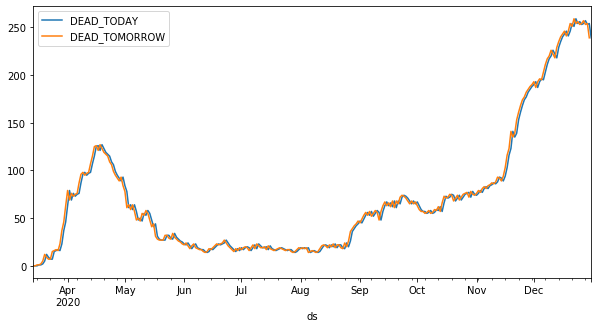

In [48]:
df['ds'] = pd.to_datetime(df['DAY'],  dayfirst = True)
df.plot(x='ds',   figsize=(10, 5))

In [49]:
print(df['ds'])

0     2020-03-14
1     2020-03-15
2     2020-03-16
3     2020-03-17
4     2020-03-18
         ...    
288   2020-12-27
289   2020-12-28
290   2020-12-29
291   2020-12-30
292   2020-12-31
Name: ds, Length: 293, dtype: datetime64[ns]


# 1)PROPHET MODELİ İCİN DATAMI HAZIRLIYORUM:

In [50]:
#Prophet Modeli:Prophet modeli için girdi olarak ‘ds’: tarih ve ‘y’: tahmin etmek istediğimiz nümerik değeri girmemiz gerekiyor 
#projede y değişkenimiz olarak günlük ölüm sayısını veriyoruz

In [51]:
newdf = df[['ds', 'DEAD_TODAY']].copy() 
df.drop(['ds'], axis=1, inplace=True)
newdf.rename(columns={'DEAD_TODAY': 'y'}, inplace=True)

newdf.tail()

,ds,y
288,2020-12-27,254
289,2020-12-28,257
290,2020-12-29,253
291,2020-12-30,254
292,2020-12-31,239


In [52]:
#Bu hücrede amaç prophet modeliyle modelin taban ve tvan değerlerini elde etmek
m = Prophet( ) #prophet sınıfından m nesnemi yaratıyorum
m.fit(newdf) #modelimi verimle eğiten "fit" fonksiyonuna newdf dataframe ini veriyorum
horizon= 1
future = m.make_future_dataframe(periods=horizon)
forecast = m.predict(future)
forecast[['ds',  'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
289,2020-12-28,262.885367,247.439697,277.976431
290,2020-12-29,266.180919,250.762861,281.629435
291,2020-12-30,270.667431,253.082075,285.174747
292,2020-12-31,273.936019,258.056093,290.286420
293,2021-01-01,277.858143,262.155954,294.003269


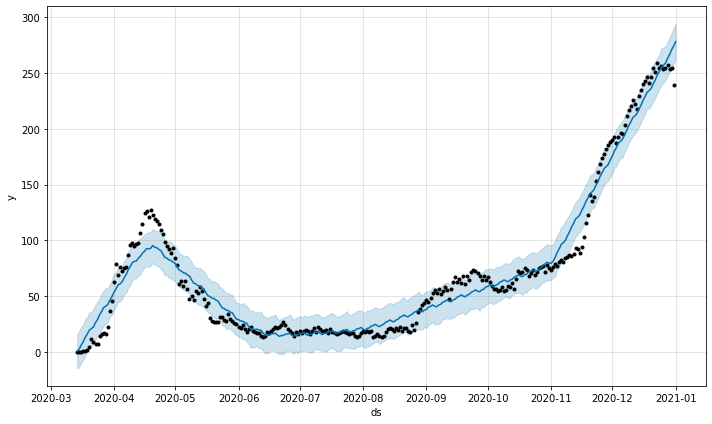

In [53]:
fig1 = m.plot(forecast)

In [54]:
#bu kısımdada prophet modelinin yaptığı yahminin hata oranını hesaplıyoruz

MAE={}

MAE['Prophet'] =  mean_absolute_error(newdf['y'], forecast[:-horizon]['yhat'])

print("MAE : {}".format(MAE))

MAE : {'Prophet': 9.755691660019027}


In [55]:
#### Prophet metodunun bir gün sonrası için yaptığı tahmin ile gerçekte o gün ölen kişilerin grafik gösterimi 

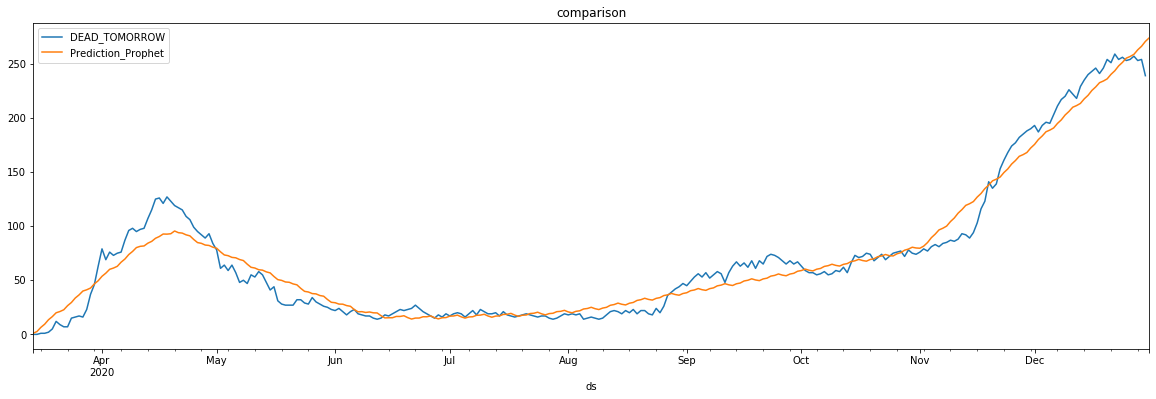

In [56]:
comparison= pd.DataFrame()
comparison['ds']=newdf['ds'].copy()
comparison['DEAD_TOMORROW']=df['DEAD_TOMORROW'].copy()
comparison['Prediction_Prophet'] = forecast[:-1].yhat
comparison.plot(title="comparison",x='ds',figsize=(20, 6))

# 2)SİMPLE MOVİNG AVERAGE (SMA) ==>Ortalama alma yöntemi

In [57]:
window= 3
df['Prediction_ SMA_3'] = df.iloc[:,1].rolling(window=window).mean()
df.head()

,DAY,DEAD_TODAY,DEAD_TOMORROW,Prediction_ SMA_3
0,14.3.2020,0,0.0,NaN
1,15.3.2020,0,0.0,NaN
2,16.3.2020,0,1.0,0.000000
3,17.3.2020,1,1.0,0.333333
4,18.3.2020,1,2.0,0.666667


<Figure size 1440x432 with 0 Axes>

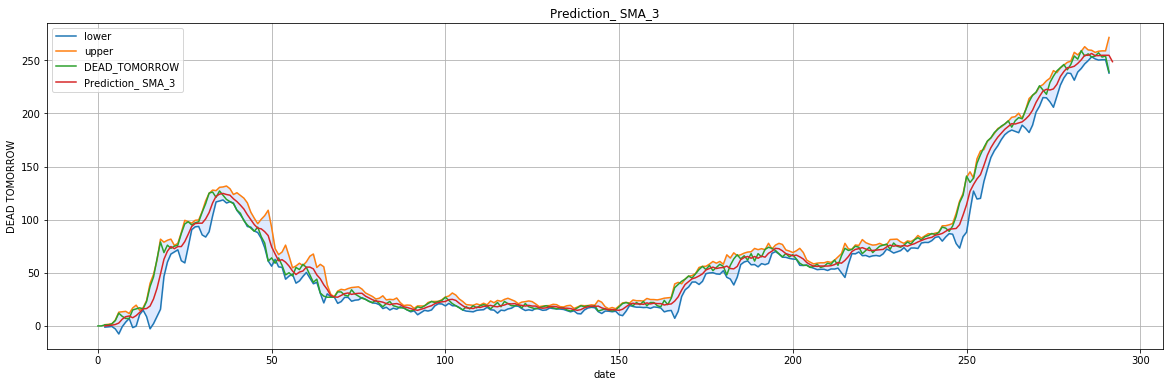

In [58]:

rstd = df.iloc[:,2].rolling(window=window).std() #2.kolonun standart sapması alınıyor
bands = pd.DataFrame()
bands['DAY']= df['DAY'].copy()
bands['lower'] = df['Prediction_ SMA_3'] - 2 * rstd #2.kolondan bulunan std sapma yardımıyla lower değer hesaplanıyor
bands['upper'] = df['Prediction_ SMA_3'] + 2 * rstd #2.kolondan bulunan std sapma yardımıyla upper değer hesaplanıyor


bands = bands.join(df['DEAD_TOMORROW']).join(df['Prediction_ SMA_3'])
fig = plt.figure(figsize=(20, 6))
ax = bands.plot(title='Prediction_ SMA_3', figsize=(20, 6))
ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
ax.set_xlabel('date')
ax.set_ylabel('DEAD TOMORROW')
ax.grid()

plt.show()

In [59]:
#Prophet metdoduyla SMA methodunun hata oranları kıyas edilip  "MAE" kümesine hata oranları ekleniyor
#SMA methodu hata oranı prophet modeline oranla daha az çıkıyor
MAE['SMA_3'] =  mean_absolute_error(df[2:-1]['DEAD_TOMORROW'], df[2:-1]['Prediction_ SMA_3'])
print("MAE : {}".format(MAE))

MAE : {'Prophet': 9.755691660019027, 'SMA_3': 4.691954022988506}


            ds  DEAD_TOMORROW  Prediction_Prophet  Prediction_SMA_3
288 2020-12-27          257.0          258.707125        254.333333
289 2020-12-28          253.0          262.885367        254.666667
290 2020-12-29          254.0          266.180919        254.666667
291 2020-12-30          239.0          270.667431        254.666667
292 2020-12-31            NaN          273.936019        248.666667


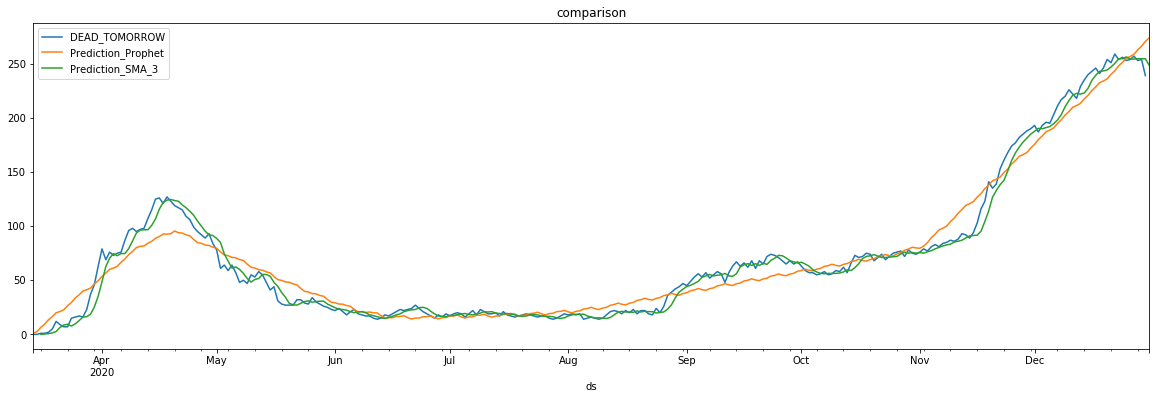

In [60]:
#tahminlerimizi tuttuğumuz comparison dataframe içerisine hergün için SMA_3 modelinin çıktılarını bir seri olarak yazıyoruz
comparison['Prediction_SMA_3'] = df['Prediction_ SMA_3']
print(comparison.tail())
comparison.plot(title="comparison",x='ds',figsize=(20, 6)) 

##Grafiktede görüldüğü üzere yeşil çizgi yani SMA doğrusu gerçek ölüm oranları yani mavi çizgiyle uyumlu gidiyor

# 3)Exponential Moving Average (EMA) 

In [61]:
#1.sütun baz alınıp predict EMA_3 kolonu değerleri elde ediliyor
df['Prediction_EMA_3'] = df.iloc[:,1].ewm(span=window,adjust=False).mean()
df.head()

,DAY,DEAD_TODAY,DEAD_TOMORROW,Prediction_ SMA_3,Prediction_EMA_3
0,14.3.2020,0,0.0,NaN,0.00
1,15.3.2020,0,0.0,NaN,0.00
2,16.3.2020,0,1.0,0.000000,0.00
3,17.3.2020,1,1.0,0.333333,0.50
4,18.3.2020,1,2.0,0.666667,0.75


<Figure size 1440x432 with 0 Axes>

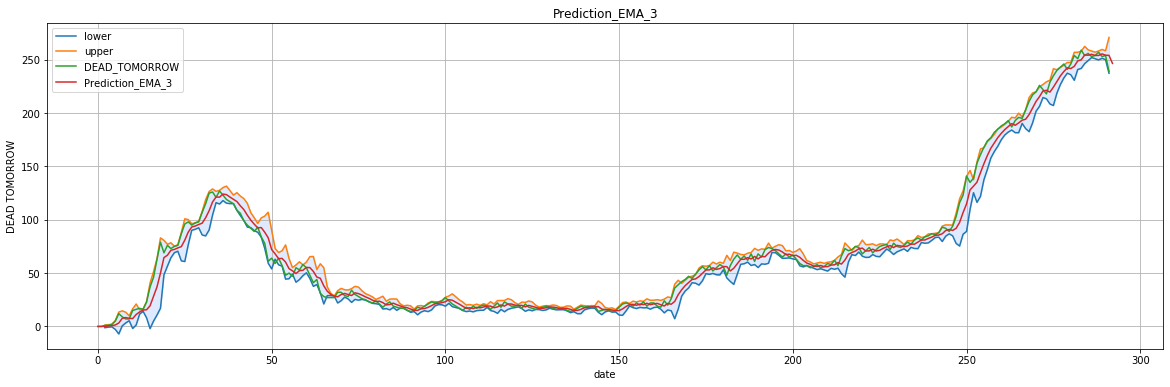

In [63]:
#EMA için standart sapma hesaplanıp matematiksel operasyonları gerçekleştiriyoruz
rstd = df.iloc[:,2].rolling(window=window).std()
bands = pd.DataFrame()

bands['DAY']= df['DAY'].copy()
bands['lower'] = df['Prediction_EMA_3'] - 2 * rstd
bands['upper'] = df['Prediction_EMA_3'] + 2 * rstd

bands = bands.join(df['DEAD_TOMORROW']).join(df['Prediction_EMA_3'])
fig = plt.figure(figsize=(20, 6))
ax = bands.plot(title='Prediction_EMA_3', figsize=(20, 6))
ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
ax.set_xlabel('date')
ax.set_ylabel('DEAD TOMORROW')
ax.grid()
plt.show()

In [62]:
#Diğer  methodlarla  EMA methodunun hata oranları kıyas edilip  "MAE" kümesine hata oranları ekleniyor
#EMA methodu hata oranı prophet modeline oranla daha az çıkıyor

MAE['EMA_3'] =  mean_absolute_error(df[1:-1]['DEAD_TOMORROW'], df[1:-1]['Prediction_EMA_3'])
print("MAE : {}".format(MAE))

MAE : {'Prophet': 9.755691660019027, 'SMA_3': 4.691954022988506, 'EMA_3': 4.534847019016072}


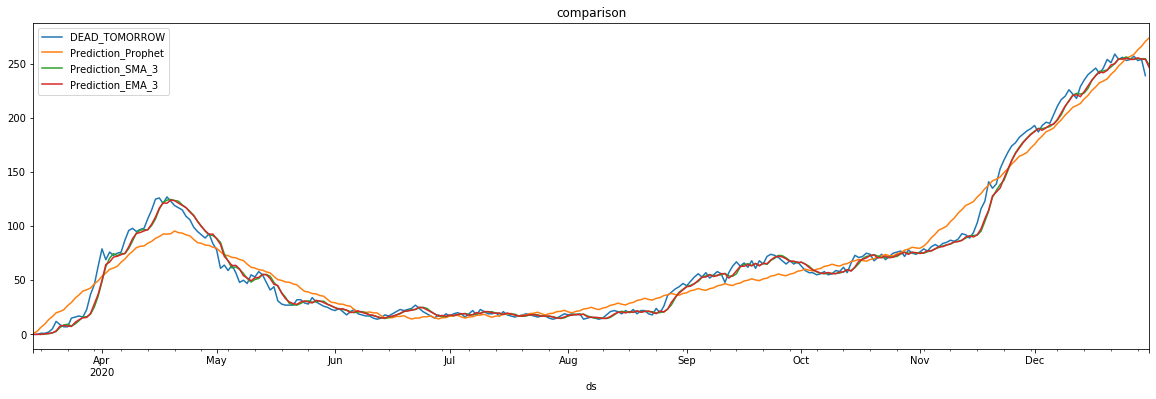

In [64]:
#3 MODEL VE GERÇEK DEĞERLERİN OLDUĞU GRAFİĞİ OLUŞTURUYORUZ
comparison['Prediction_EMA_3'] = df['Prediction_EMA_3']
comparison.plot(title="comparison",x='ds',figsize=(20, 6))

In [65]:
print('Mean Absolute Errors (MAE): {}'.format(MAE))

Mean Absolute Errors (MAE): {'Prophet': 9.755691660019027, 'SMA_3': 4.691954022988506, 'EMA_3': 4.534847019016072}


In [67]:
rstd.tail()

288    2.081666
289    2.081666
290    2.081666
291    8.386497
292         NaN
Name: DEAD_TOMORROW, dtype: float64

In [68]:
#EMA_3'E AİT GÜNLÜK TAHMİNLER  VE GERÇEK DEĞERLER
bands.tail()

,DAY,lower,upper,DEAD_TOMORROW,Prediction_EMA_3
288,27.12.2020,249.866861,258.193525,257.0,254.030193
289,28.12.2020,251.351764,259.678428,253.0,255.515096
290,29.12.2020,250.094216,258.420880,254.0,254.257548
291,30.12.2020,237.355780,270.901768,239.0,254.128774
292,31.12.2020,NaN,NaN,NaN,246.564387


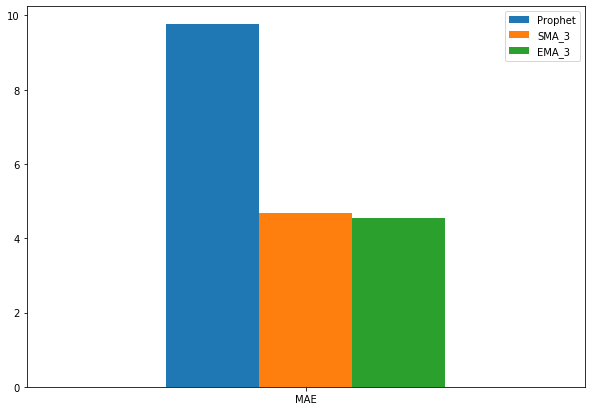

In [66]:
#3 MODELİN HATA ORANI GRAFİĞİ
errorsDF = pd.DataFrame(MAE, index=['MAE']) 
ax = errorsDF.plot.bar(rot=0, figsize=(10, 7))